### Ingest math and language arts state test participation 

In [92]:
# Look at columns in files one at a time before we upload to worm
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [93]:
dataset_dir = "/home/bb/datasets/state_test_participation/"

os.chdir(dataset_dir)
math_files = []
rla_files = []
for root, dirs, files in os.walk('.', topdown=False):
    for f in files:
        if f.startswith("math"):
            math_files += [f]
        if f.startswith("rla"):
            rla_files += [f]
        print(f)


math-participation-sch-sy2018-19-wide.csv
rla-participation-sch-sy2012-13.csv
rla-participation-sch-sy2015-16.csv
math-participation-sch-sy2016-17.csv
math-participation-sch-sy2012-13.csv
math-participation-sch-sy2014-15.csv
math-participation-sch-sy2013-14.csv
rla-participation-sch-sy2018-19-wide.csv
rla-participation-sch-sy2017-18.csv
math-participation-sch-sy2015-16.csv
rla-participation-sch-sy2016-17.csv
rla-participation-sch-sy2013-14.csv
math-participation-sch-sy2017-18.csv
rla-participation-sch-sy2014-15.csv


In [94]:
# We are missing the years 2010-2011 and 2011-2012. Possibly we can impute the values.
# Lets look at the feature overlap


In [95]:
# We have 7 years of Math percent participated scores
len(math_files), len(rla_files)


(7, 7)

In [96]:
# Create raw math and rla dataframe lists
math_dfs = [pd.read_csv(dataset_dir + "/" + i, low_memory=False)
            for i in math_files]
rla_dfs = [pd.read_csv(dataset_dir + "/" + i, low_memory=False)
           for i in rla_files]


In [97]:
# Example of the shape of one of the datrames
math_dfs[0].shape, math_dfs[0].columns.tolist()


((90320, 265),
 ['STNAM',
  'FIPST',
  'LEANM',
  'LEAID',
  'ST_LEAID',
  'NCESSCH',
  'ST_SCHID',
  'SCHNAM',
  'DATE_CUR',
  'ALL_MTH00numpart_1819',
  'ALL_MTH00pctpart_1819',
  'MAM_MTH00numpart_1819',
  'MAM_MTH00pctpart_1819',
  'MAS_MTH00numpart_1819',
  'MAS_MTH00pctpart_1819',
  'MBL_MTH00numpart_1819',
  'MBL_MTH00pctpart_1819',
  'MHI_MTH00numpart_1819',
  'MHI_MTH00pctpart_1819',
  'MTR_MTH00numpart_1819',
  'MTR_MTH00pctpart_1819',
  'MWH_MTH00numpart_1819',
  'MWH_MTH00pctpart_1819',
  'F_MTH00numpart_1819',
  'F_MTH00pctpart_1819',
  'M_MTH00numpart_1819',
  'M_MTH00pctpart_1819',
  'CWD_MTH00numpart_1819',
  'CWD_MTH00pctpart_1819',
  'ECD_MTH00numpart_1819',
  'ECD_MTH00pctpart_1819',
  'FCS_MTH00numpart_1819',
  'FCS_MTH00pctpart_1819',
  'LEP_MTH00numpart_1819',
  'LEP_MTH00pctpart_1819',
  'HOM_MTH00numpart_1819',
  'HOM_MTH00pctpart_1819',
  'MIG_MTH00numpart_1819',
  'MIG_MTH00pctpart_1819',
  'MIL_MTH00numpart_1819',
  'MIL_MTH00pctpart_1819',
  'ALL_MTH03numpar

In [98]:
# Inspecting the codebook, we see that there are only two columns relevant to our study.
# These are the percentage participation numbers in math and reading / language arts state assessments.
# Extract the total participation column names that are relevant to high schools
list(map(lambda x: print(x.filter(like="ALL_MTHHSPCT").columns), math_dfs))
list(map(lambda x: print(x.filter(like="ALL_RLAHSPCT").columns), rla_dfs))
list(map(lambda x: print(x.filter(like="NCESSCH").columns), math_dfs))
list(map(lambda x: print(x.filter(like="NCESSCH").columns), rla_dfs))


Index([], dtype='object')
Index(['ALL_MTHHSPCTPART_1617'], dtype='object')
Index(['ALL_MTHHSPCTPART_1213'], dtype='object')
Index(['ALL_MTHHSPCTPART_1415'], dtype='object')
Index(['ALL_MTHHSPCTPART_1314'], dtype='object')
Index(['ALL_MTHHSPCTPART_1516'], dtype='object')
Index(['ALL_MTHHSPCTPART_1718'], dtype='object')
Index(['ALL_RLAHSPCTPART_1213'], dtype='object')
Index(['ALL_RLAHSPCTPART_1516'], dtype='object')
Index([], dtype='object')
Index(['ALL_RLAHSPCTPART_1718'], dtype='object')
Index(['ALL_RLAHSPCTPART_1617'], dtype='object')
Index(['ALL_RLAHSPCTPART_1314'], dtype='object')
Index(['ALL_RLAHSPCTPART_1415'], dtype='object')
Index(['NCESSCH'], dtype='object')
Index(['NCESSCH'], dtype='object')
Index(['NCESSCH'], dtype='object')
Index(['NCESSCH'], dtype='object')
Index(['NCESSCH'], dtype='object')
Index(['NCESSCH'], dtype='object')
Index(['NCESSCH'], dtype='object')
Index(['NCESSCH'], dtype='object')
Index(['NCESSCH'], dtype='object')
Index(['NCESSCH'], dtype='object')
Index(['NC

[None, None, None, None, None, None, None]

### Strategy:
* Subset the dataframes to our columns of interest e.g. (NCESSCH, ALL_MTHHSPCTPART_1213, ALL_RLAHSPCTPART_1213)
* Create one large math and one large language arts dataframe with all the years stacked, so that it matches our graduation rate and school directory dataframes
* Explore statistics and missing values
* Save these two dataframes to disk

In [99]:
def year_string(y: int):
    """Input an integer year and get a range that matches the column suffixes in the raw data.
    e.g. 2011 => 1112 and 2018 => 1819."""
    return str(y)[-2:] + str(int(str(y)[-2:]) + 1)


In [100]:
# Produce large dataframes joined by year

new_math_dfs = []
new_rla_dfs = []

for df in math_dfs:
    pct_part = df.loc[:, [
        'ALL_MTHHSPCT' in i or 'ALL_MTHHSpct' in i for i in df.columns]]
    unaltered_year = pct_part.columns[0][-4:]
    year = int("20" + pct_part.columns[0][-4:-2])
    year_df = pd.DataFrame()
    year_df['Year'] = np.array([year] * len(pct_part))
    ncessch = df.filter(like='NCESSCH')
    pct_part.rename(mapper={"ALL_MTHHSPCTPART_" +
                    unaltered_year: "Math_Pct_Part"}, axis=1, inplace=True)
    pct_part.rename(mapper={"ALL_MTHHSpctpart_" +
                    unaltered_year: "Math_Pct_Part"}, axis=1, inplace=True)
    assert isinstance(pct_part, pd.DataFrame)
    assert isinstance(year_df, pd.DataFrame)
    assert isinstance(ncessch, pd.DataFrame)
    assert len(pct_part) == len(year_df) == len(ncessch)
    new_df = pd.concat([year_df, ncessch, pct_part], axis=1)
    new_math_dfs += [new_df]


for df in rla_dfs:
    pct_part = df.loc[:, [
        'ALL_RLAHSPCT' in i or 'ALL_RLAHSpct' in i for i in df.columns]]
    unaltered_year = pct_part.columns[0][-4:]
    year = int("20" + pct_part.columns[0][-4:-2])
    year_df = pd.DataFrame()
    year_df['Year'] = np.array([year] * len(pct_part))
    ncessch = df.filter(like='NCESSCH')
    pct_part.rename(mapper={"ALL_RLAHSPCTPART_" +
                    unaltered_year: "Rla_Pct_Part"}, axis=1, inplace=True)
    pct_part.rename(mapper={"ALL_RLAHSpctpart_" +
                    unaltered_year: "Rla_Pct_Part"}, axis=1, inplace=True)
    assert isinstance(pct_part, pd.DataFrame)
    assert isinstance(year_df, pd.DataFrame)
    assert isinstance(ncessch, pd.DataFrame)
    assert len(pct_part) == len(year_df) == len(ncessch)
    new_df = pd.concat([year_df, ncessch, pct_part], axis=1)
    new_rla_dfs += [new_df]


/tmp/ipykernel_257762/2146115944.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pct_part.rename(mapper={"ALL_MTHHSPCTPART_" +
/tmp/ipykernel_257762/2146115944.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pct_part.rename(mapper={"ALL_MTHHSpctpart_" +
/tmp/ipykernel_257762/2146115944.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pct_part.rename(mapper={"ALL_MTHHSPCTPART_" +
/tmp/ipykernel_257762/2146115944.py:16: Set

In [101]:
big_math_df = pd.concat(new_math_dfs, axis=0)
big_rla_df = pd.concat(new_rla_dfs, axis=0)
# Merge RLA and PCT prof on 'Year' and 'Ncessch"
merged_data = big_math_df.merge(big_rla_df, on=["Year", "NCESSCH"])


In [102]:
merged_data


,Year,NCESSCH,Math_Pct_Part,Rla_Pct_Part
0,2018,10000500870,NaN,NaN
1,2018,10000500871,98,98
2,2018,10000500879,NaN,NaN
3,2018,10000500889,NaN,NaN
4,2018,10000600193,NaN,NaN
...,...,...,...,...
623451,2017,560609000401,GE90,GE90
623452,2017,560624000343,GE95,GE95
623453,2017,560624000344,NaN,NaN
623454,2017,560624000577,NaN,NaN


<AxesSubplot: xlabel='Year', ylabel='count'>

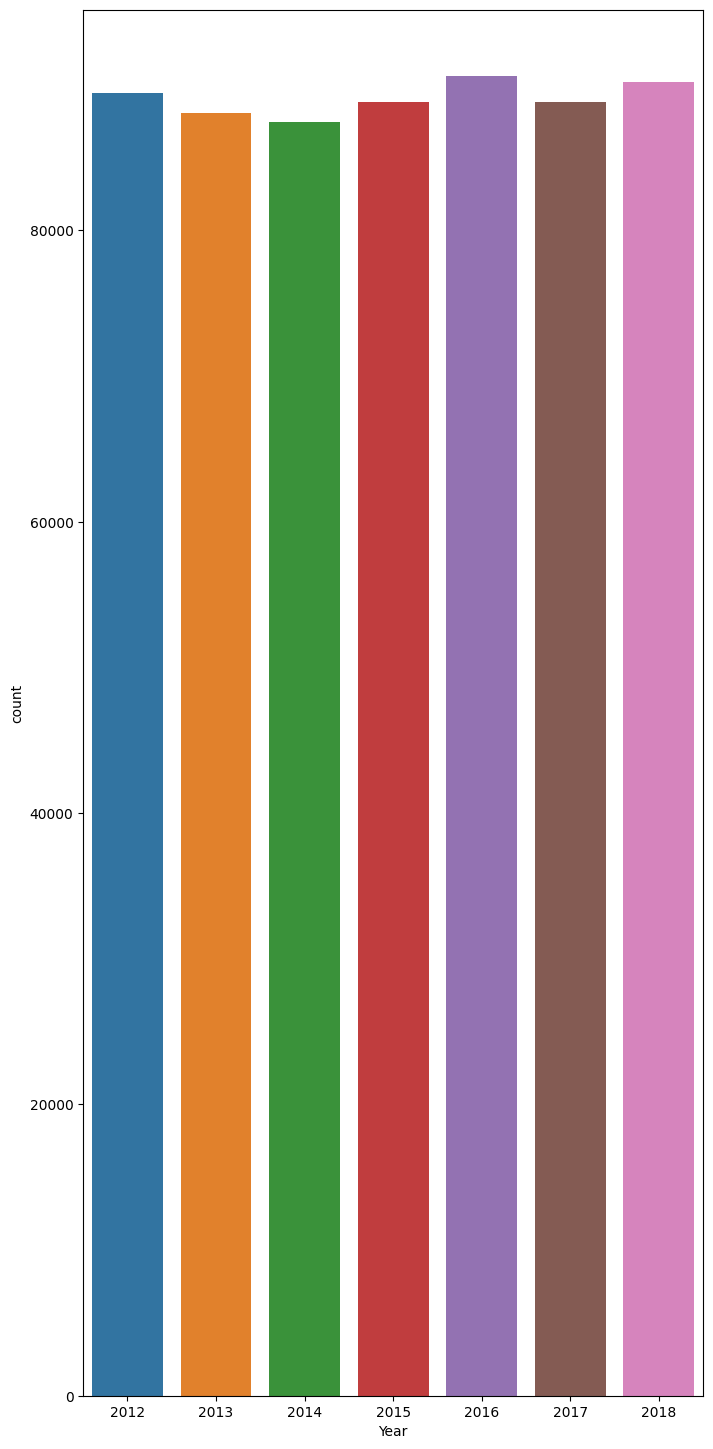

In [103]:
# Explore Percent Participation, Year, and Ncessch
sns.countplot(data=merged_data, x='Year')


<AxesSubplot: xlabel='count', ylabel='Rla_Pct_Part'>

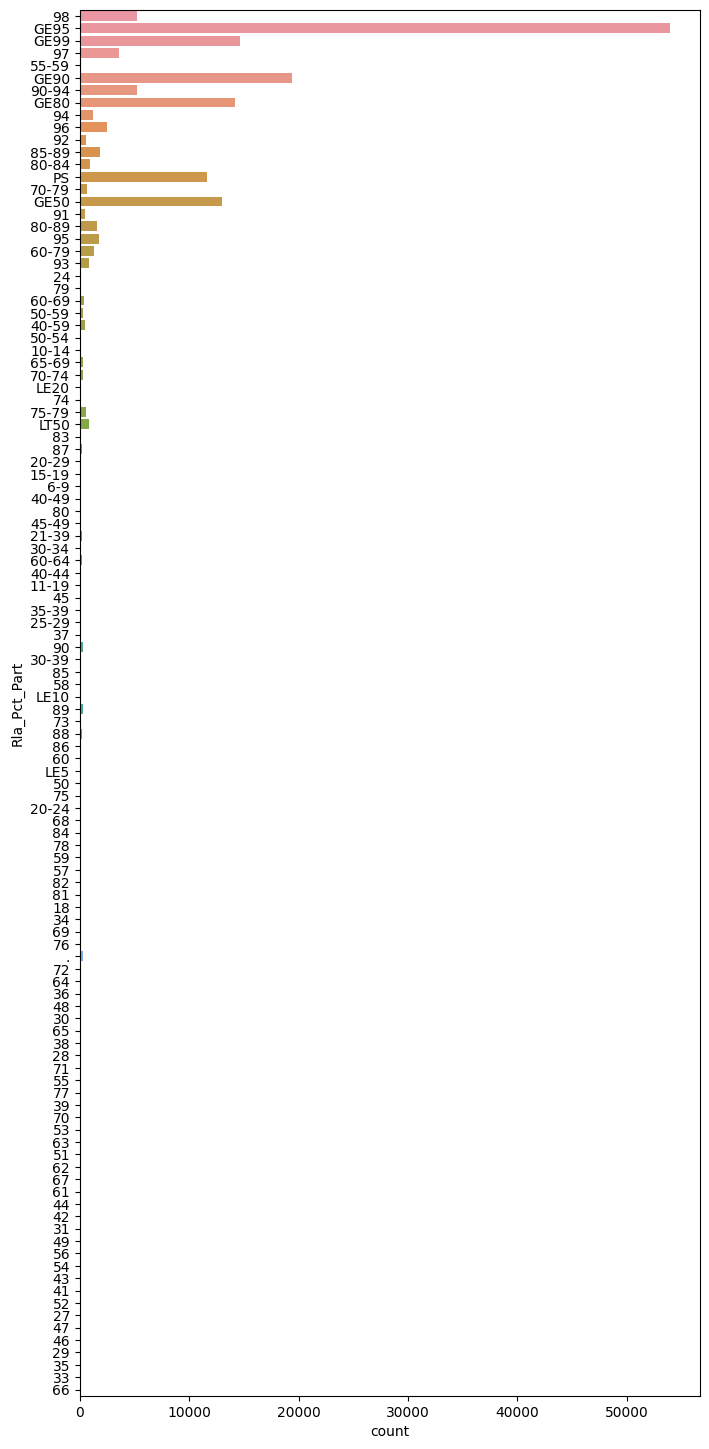

In [104]:
plt.rcParams['figure.figsize'] = (8, 18)
sns.countplot(data=merged_data, y='Rla_Pct_Part')


<AxesSubplot: xlabel='count', ylabel='Math_Pct_Part'>

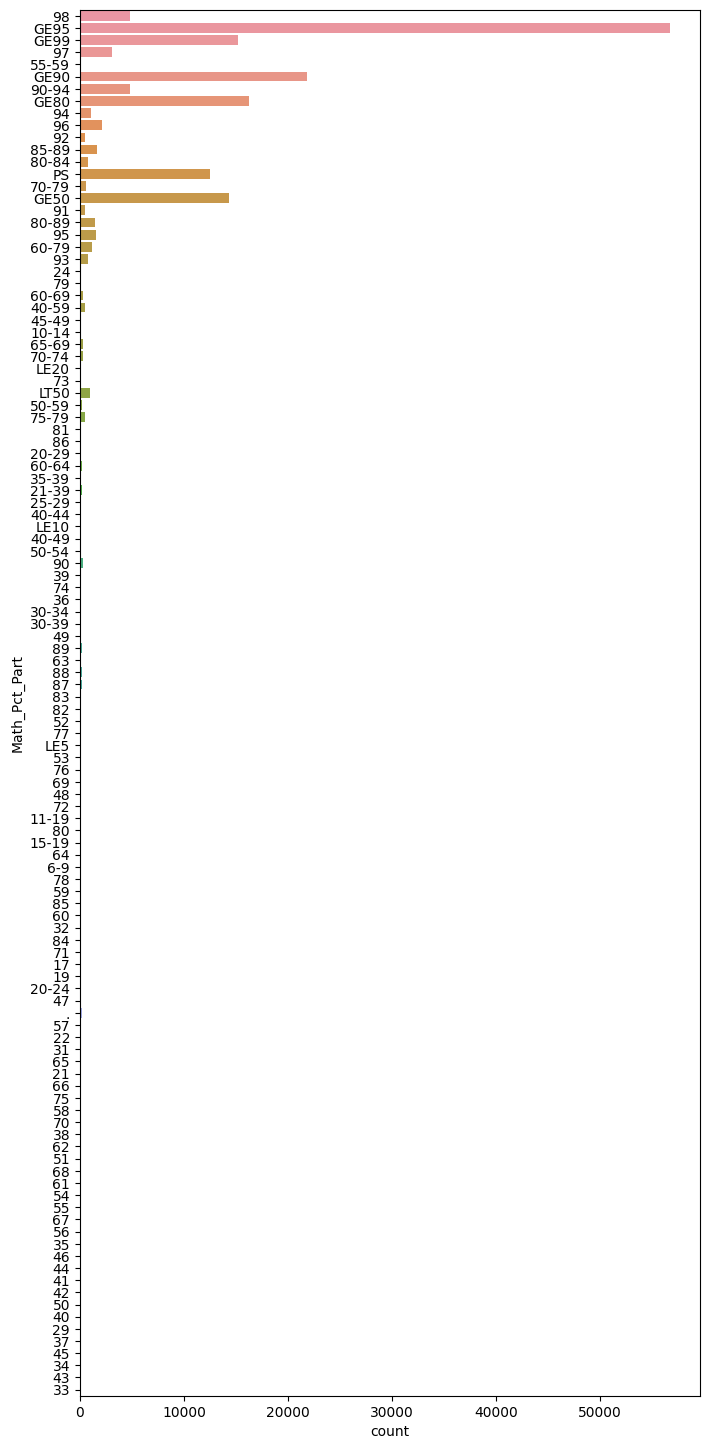

In [105]:
plt.rcParams['figure.figsize'] = (8, 18)
sns.countplot(data=merged_data, y='Math_Pct_Part')


Observation
There are 12-15000 schools with a 'PS' for percent participated, indicating that they had such small graduating cohorts that they were not included in the study. Note that schools marked with PS in the graduation rate dataset were dropped due to not having a valid target variable value to train or test a model on.

In [106]:
merged_data


,Year,NCESSCH,Math_Pct_Part,Rla_Pct_Part
0,2018,10000500870,NaN,NaN
1,2018,10000500871,98,98
2,2018,10000500879,NaN,NaN
3,2018,10000500889,NaN,NaN
4,2018,10000600193,NaN,NaN
...,...,...,...,...
623451,2017,560609000401,GE90,GE90
623452,2017,560624000343,GE95,GE95
623453,2017,560624000344,NaN,NaN
623454,2017,560624000577,NaN,NaN


In [107]:
merged_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 623456 entries, 0 to 623455
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Year           623456 non-null  int64 
 1   NCESSCH        623456 non-null  int64 
 2   Math_Pct_Part  169286 non-null  object
 3   Rla_Pct_Part   161320 non-null  object
dtypes: int64(2), object(2)
memory usage: 23.8+ MB


In [108]:
# @TODO: Need to convert the stringified numerical values in the Pct_Part columns to numeric values. We can use the function from the graduation rate 
# EDA notebook to do this.